# Modèles avancés (20%) 

In [1]:
from comet_ml import Experiment

In [2]:
from dotenv import load_dotenv
import os

In [54]:
load_dotenv(r".env")

True

In [55]:
comet_api_key = os.environ.get('COMET_API_KEY')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import CalibrationDisplay, calibration_curve
import pickle
from plots import *

### 1. Classificateur XGBoost en utilisant uniquement les caractéristiques de distance et d'angle 

#### Loading data

In [6]:
data_path = os.environ.get('DATA_DIR')

In [7]:
train_data_path = data_path+"\\nhl_train_data.csv"
test_data_path = data_path+"\\nhl_test_data.csv"

In [8]:
train_data=pd.read_csv(train_data_path)
test_data=pd.read_csv(test_data_path)

In [9]:
train_data.sample(3)

,Unnamed: 0.1,Unnamed: 0,emptyNet,x,y,isGoal,distanceToNet,relativeAngleToNet,season
214295,214295,909,0,54.0,-3.0,0,36.124784,-1.193489,2018
53167,53167,873,0,-67.0,-6.0,1,23.769729,-14.620874,2016
267379,267379,473,0,51.0,-20.0,0,43.829214,-8.073205,2019


In [10]:
print(train_data.shape)
print(test_data.shape)

(305797, 9)
(52408, 9)


#### Création du modèle XGBoost et son évaluation

In [11]:
experience_comet = False

c:\Users\Prevot\anaconda3\envs\ift6758\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


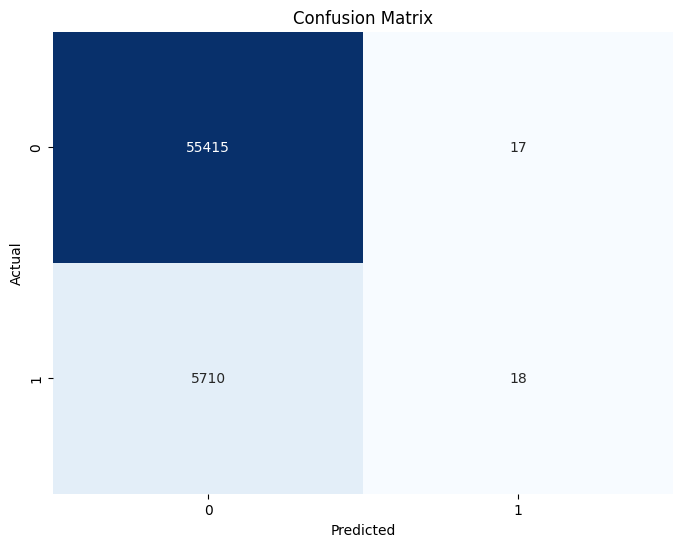

Accuracy: 0.9063603662524525
Accuracy pour la classe 0 : 0.9996933179390965
Accuracy pour la classe 1 : 0.0031424581005586594


In [12]:
if experience_comet : 
    experience = Experiment(
        api_key=os.environ.get(comet_api_key),
        project_name='milestone2',
        workspace='ift6758-a02',
    )
    experience.set_name("Modèle XGBoost avec distance et angle")

# On garde que les caractéristique qu'on veut étudier ici
X_train_select = train_data[['distanceToNet', 'relativeAngleToNet']]
y_train_select = train_data['isGoal']

# Split l'ensemble de données en ensembles d'entraînement et de validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train_select, y_train_select, test_size=0.2, random_state=42)


# Initialisation du modèle XGBoost
model = xgb.XGBClassifier()

# Entraîenement
model.fit(X_train, y_train, eval_metric=["logloss"], eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=False)

# prédictions sur l'ensemble de validation
y_pred = model.predict(X_valid)

# Matrice de confusion
conf_matrix = confusion_matrix(y_valid, y_pred)
#print(f"Confusion Matrix:\n{conf_matrix}")
# Visualisation de la matrice de confusion avec Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
if experience_comet :
    plt.savefig("images/matrix_conf_XGBoost_dist_angle.png")
plt.show()

# Accuracy
accuracy = accuracy_score(y_valid, y_pred)
print(f"Accuracy: {accuracy}")

# Calcul des accuracies par classe
accuracy_class_0 = (y_pred[y_valid.values == 0] == 0).sum() / (y_valid.values == 0).sum()
accuracy_class_1 = (y_pred[y_valid.values == 1] == 1).sum() / (y_valid.values == 1).sum()

# Affichage des résultats
print(f"Accuracy pour la classe 0 : {accuracy_class_0}")
print(f"Accuracy pour la classe 1 : {accuracy_class_1}")

if experience_comet : 
    pickle.dump(model, open("models/XGBoost_dist_angle.json", "wb"))

    experience.log_model("Modèle XGBoost", "models/XGBoost_dist_angle.json")
    experience.log_confusion_matrix(y_true=y_valid, y_predicted=y_pred, title="XGBoost Confusion Matrix")
    experience.log_metric("accuracy", accuracy)
    experience.add_tag("XGBoost")
    experience.end()


### Figures

#### i) ROC/AUC

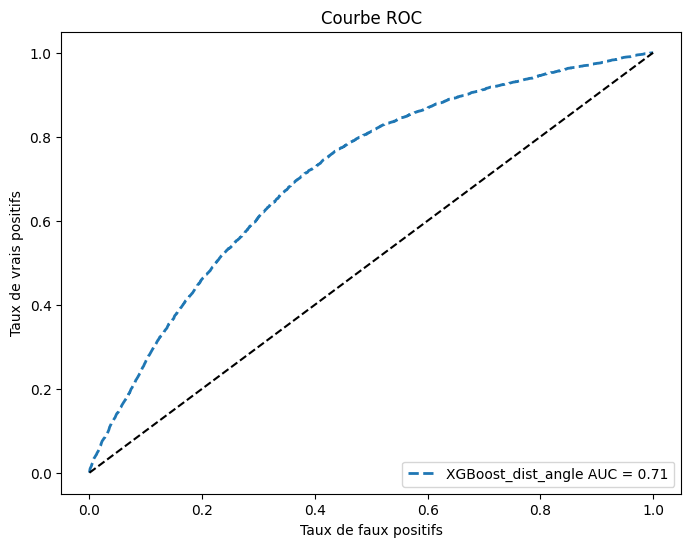

In [13]:
plot_roc_auc([model], [X_valid], [y_valid], ["XGBoost_dist_angle"])

#### ii) Taux de buts vs percentile de probabilité

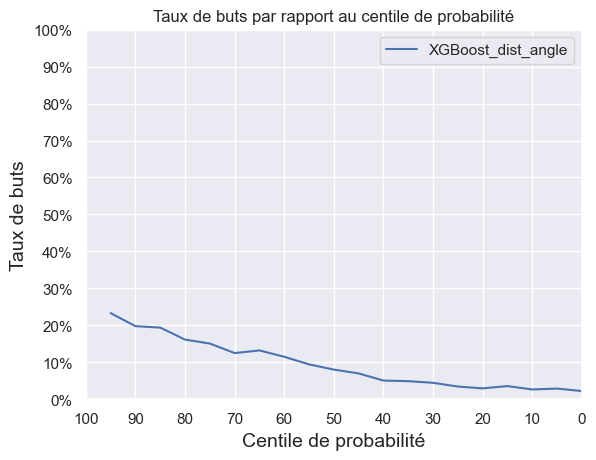

In [14]:
plot_taux_buts_par_centile([model], [X_valid], [y_valid], ["XGBoost_dist_angle"])

#### iii) Proportion cumulée de buts vs percentile de probabilité

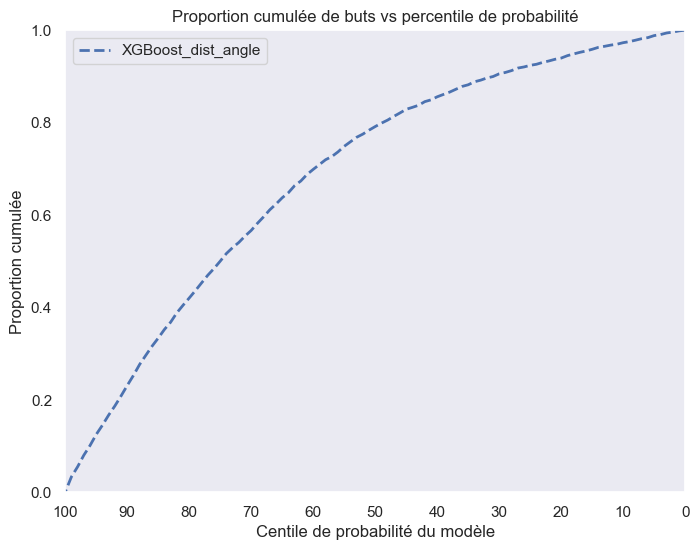

In [15]:
cumulative_goal_rate([model], [X_valid], [y_valid], ["XGBoost_dist_angle"])

#### iv) Courbe de fiabilité

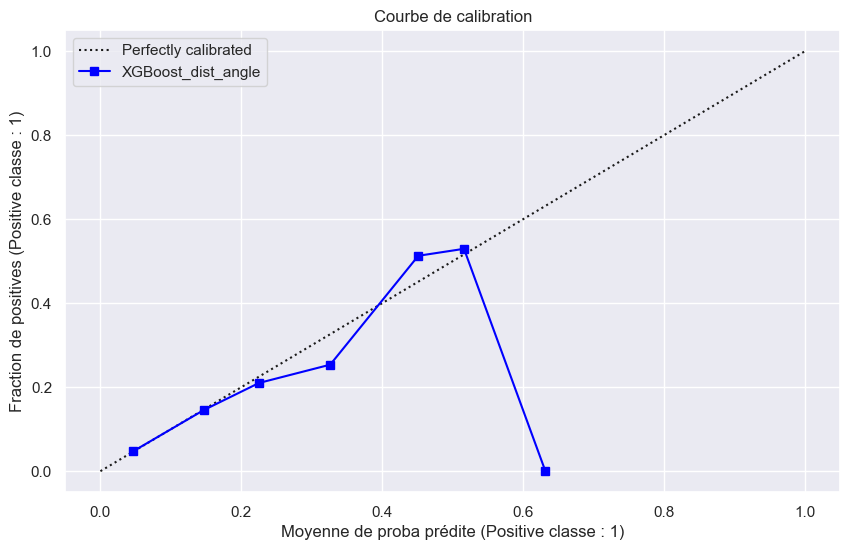

In [16]:
plot_calibration_curve([model], [X_valid], [y_valid], ["XGBoost_dist_angle"])

### 2. Classificateur XGBoost en utilisant toutes les caractéristiques créées dans la Partie 4 

In [17]:
train_data_path_2 = data_path+"\\nhl_2016to2019_previous_v2_0.csv"
test_data_path_2 = data_path+"\\nhl_data_2020_previous_v2_0.csv"

In [18]:
train_data_2=pd.read_csv(train_data_path_2)
test_data_2=pd.read_csv(test_data_path_2)

In [19]:
train_data_2.sample(3)

,period,periodTimeInSeconds,isGoal,typeDeTir,x,y,distanceToNet,relativeAngleToNet,previousEventTypeId,previousX,previousY,distanceFromPrevious,timeDiff,rebond,angleChange,vitesse,season
171701,1.0,502,0,Wrist Shot,-38.0,-30.0,60.033324,-29.981639,SHOT,-62.0,17.0,52.77,28,True,61.245371,1.884643,2018
110588,3.0,864,0,Wrist Shot,-66.0,-15.0,28.301943,-32.005383,BLOCKED_SHOT,-79.0,-12.0,13.34,17,False,0.000000,0.784706,2017
209484,3.0,855,0,Wrist Shot,-48.0,8.0,42.755117,10.784298,FACEOFF,69.0,22.0,117.83,31,False,0.000000,3.800968,2018


In [20]:
print(train_data_2.shape)
print(test_data_2.shape)

(305797, 17)
(52408, 17)


On vérifie s'il y a des NaN et on enlève les lignes correspondantes si c'est le cas.

In [21]:
# Vérifier s'il y a des NaN dans tout le DataFrame
nan_nb = train_data_2.isna().any().sum()

# Afficher le résultat
print(f"Y a-t-il des NaN dans le DataFrame ? {nan_nb}")

# Vérifier s'il y a des NaN dans chaque colonne
nan_columns = train_data_2.columns[train_data_2.isna().any()]

# Afficher les colonnes avec des NaN
if not nan_columns.empty:
    print(f"Colonnes avec des NaN : {nan_columns}")
else:
    print("Aucune colonne avec NaN.")


Y a-t-il des NaN dans le DataFrame ? 6
Colonnes avec des NaN : Index(['typeDeTir', 'previousX', 'previousY', 'distanceFromPrevious',
       'angleChange', 'vitesse'],
      dtype='object')


In [22]:
train_data_2.dropna(inplace=True)

Pareil pour les valeurs infinies

In [23]:
# Calculer la proportion de valeurs infinies dans le dataframe
inf_proportion = train_data_2.replace([np.inf, -np.inf], np.nan).isna().mean().mean()

# Afficher le nombre total de lignes dans le dataframe
num_rows = len(train_data_2)

print(f"Proportion de valeurs infinies : {inf_proportion:.2%}")
print(f"Nombre total de lignes dans le dataframe : {num_rows}")


Proportion de valeurs infinies : 0.11%
Nombre total de lignes dans le dataframe : 301594


Au vu de la proportion de valeurs infinies et de la taille des données, on préfère simplement supprimer ces lignes correspondantes plutot que de les modifier en faisant une moyenne sur toutes la colonnes par exemple

In [24]:
train_data_2 = train_data_2.replace([np.inf, -np.inf], np.nan).dropna()

Comme on doit utiliser toutes les caractéristiques, on doit vérifier qu'elles sont dans le bon format pour un entraînement

In [25]:
train_data_2.dtypes

period                  float64
periodTimeInSeconds       int64
isGoal                    int64
typeDeTir                object
x                       float64
y                       float64
distanceToNet           float64
relativeAngleToNet      float64
previousEventTypeId      object
previousX               float64
previousY               float64
distanceFromPrevious    float64
timeDiff                  int64
rebond                     bool
angleChange             float64
vitesse                 float64
season                    int64
dtype: object

Ici, certaines caractéristiques vont poser problème si on ne les modifie pas (ex : typeDeTir et previousEventTypeId), on va alors créer plus de caractéristiques comme typeDeTir_Backhand avec des valeurs à 0 ou 1 si le type du tir est 'backhand' ou non.

In [26]:
dummy_object = pd.get_dummies(train_data_2[['typeDeTir', 'previousEventTypeId']])
data = train_data_2.merge(dummy_object, left_index=True, right_index=True)
train_data_2_correct = data.drop(labels = ['typeDeTir', 'previousEventTypeId'], axis = 1)

In [27]:
train_data_2_correct.dtypes

period                              float64
periodTimeInSeconds                   int64
isGoal                                int64
x                                   float64
y                                   float64
distanceToNet                       float64
relativeAngleToNet                  float64
previousX                           float64
previousY                           float64
distanceFromPrevious                float64
timeDiff                              int64
rebond                                 bool
angleChange                         float64
vitesse                             float64
season                                int64
typeDeTir_Backhand                     bool
typeDeTir_Deflected                    bool
typeDeTir_Slap Shot                    bool
typeDeTir_Snap Shot                    bool
typeDeTir_Tip-In                       bool
typeDeTir_Wrap-around                  bool
typeDeTir_Wrist Shot                   bool
previousEventTypeId_BLOCKED_SHOT

#### Création du modèle XGBoost avec toutes les caractéristiques et son évaluation

In [28]:
experience_comet = False

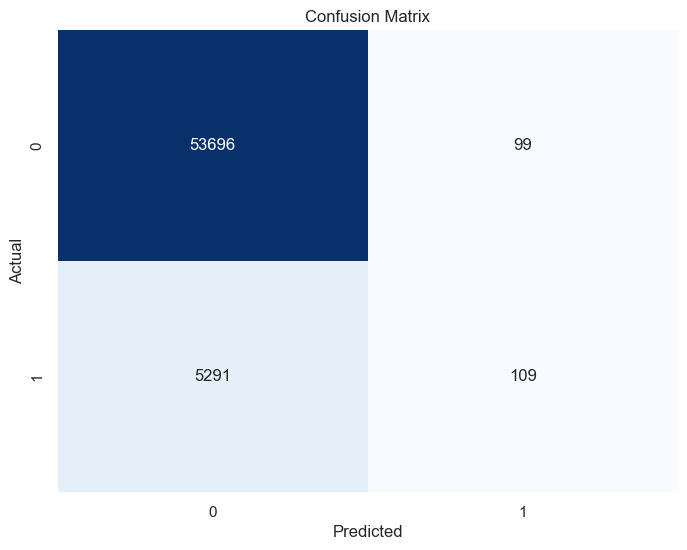

Accuracy: 0.908945012247656
Accuracy pour la classe 0 : 0.9981596802676829
Accuracy pour la classe 1 : 0.020185185185185184


In [29]:
if experience_comet : 
    experience = Experiment(
        api_key=os.environ.get(comet_api_key),
        project_name='milestone2',
        workspace='ift6758-a02',
    )
    experience.set_name("XGBoost model all features")

# on garde que les caractéristique qu'on veut étudier ici
X_train_select = train_data_2_correct.drop('isGoal', axis=1)
y_train_select = train_data_2_correct['isGoal']

# split l'ensemble de données en ensembles d'entraînement et de validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train_select, y_train_select, test_size=0.2, random_state=42)

# Initialisation du modèle XGBoost
model = xgb.XGBClassifier()

# Entraîenement
model.fit(X_train, y_train)

# prédictions sur l'ensemble de validation
y_pred = model.predict(X_valid)

# Matrice de confusion
conf_matrix = confusion_matrix(y_valid, y_pred)
#print(f"Confusion Matrix:\n{conf_matrix}")
# Visualisation de la matrice de confusion avec Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
if experience_comet :
    plt.savefig("images/matrix_conf_XGBoost_all_features.png")
plt.show()

# Accuracy
accuracy = accuracy_score(y_valid, y_pred)
print(f"Accuracy: {accuracy}")

# Calcul des accuracies par classe
accuracy_class_0 = (y_pred[y_valid.values == 0] == 0).sum() / (y_valid.values == 0).sum()
accuracy_class_1 = (y_pred[y_valid.values == 1] == 1).sum() / (y_valid.values == 1).sum()

# Affichage des résultats
print(f"Accuracy pour la classe 0 : {accuracy_class_0}")
print(f"Accuracy pour la classe 1 : {accuracy_class_1}")

if experience_comet : 

    pickle.dump(model, open("models/XGBoost_all_features.json", "wb"))

    experience.log_model("Modèle XGBoost", "models/XGBoost_all_features.json")
    experience.log_confusion_matrix(y_true=y_valid, y_predicted=y_pred, title="XGBoost Confusion Matrix")
    experience.log_metric("accuracy", accuracy)
    experience.add_tag("XGBoost")

    experience.end()


#### Recherche des meilleurs hyperparamètres pour ce modèle avec toutes les caractéristiques

In [30]:
optim_param = False

if optim_param : 
    # Définir l'espace des hyperparamètres que vous souhaitez explorer
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'min_child_weight': [1, 2, 3],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
    }

    # Initialiser le modèle XGBoost
    model = xgb.XGBClassifier()

    # Initialiser la recherche par grille avec validation croisée
    grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)

    # Entraîner la recherche par grille sur l'ensemble d'entraînement
    grid_search.fit(X_train, y_train)

    # Afficher les meilleurs hyperparamètres et la meilleure performance
    print("Meilleurs hyperparamètres : ", grid_search.best_params_)
    print("Meilleure performance (accuracy) : ", grid_search.best_score_)

Meilleurs hyperparamètres :  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 1.0}

Meilleure performance (accuracy) :  0.90910050658641

In [31]:
experience_comet = False

In [32]:
if experience_comet : 
    experience = Experiment(
        api_key=os.environ.get(comet_api_key),
        project_name='milestone2',
        workspace='ift6758-a02',
    )
    experience.set_name("XGBoost model all features with best hyperparameters")

# Hyperparamètres
best_hyperparameters = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 1.0}
#param = {'learning_rate': 0.1, 'max_depth':4, 'n_estimators': 150,'nthread': 4}

# Initialisation du modèle XGBoost avec les hyperparamètres
best_model = xgb.XGBClassifier(**best_hyperparameters)

# Entraîenement
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_valid)

# Afficher l'accuracy du modèle avec les meilleurs hyperparamètres sur l'ensemble de validation
best_accuracy = accuracy_score(y_valid, y_pred)
print(f"Accuracy avec meilleurs hyperparamètres : {accuracy}")

# Calcul des accuracies par classe
accuracy_class_0 = (y_pred[y_valid.values == 0] == 0).sum() / (y_valid.values == 0).sum()
accuracy_class_1 = (y_pred[y_valid.values == 1] == 1).sum() / (y_valid.values == 1).sum()

# Affichage des résultats
print(f"Accuracy pour la classe 0 : {accuracy_class_0}")
print(f"Accuracy pour la classe 1 : {accuracy_class_1}")

if experience_comet : 

    pickle.dump(model, open("models/best_XGBoost_all_features.json", "wb"))

    experience.log_model("best XGBoost model", "models/best_XGBoost_all_features.json")
    experience.log_confusion_matrix(y_true=y_valid, y_predicted=y_pred, title="best XGBoost Confusion Matrix")
    experience.log_parameters(best_hyperparameters)
    experience.log_metric("best accuracy", best_accuracy)
    experience.add_tag("XGBoost")

    experience.end()

Accuracy avec meilleurs hyperparamètres : 0.908945012247656
Accuracy pour la classe 0 : 0.9991263128543545
Accuracy pour la classe 1 : 0.015185185185185185


Il est à noté que l'accuracy augmente légèrement mais celle de la classe but diminue.

#### Figures

In [33]:
# XGBoost sur distance et angle

# On garde que les caractéristique qu'on veut étudier ici
X_train_select = train_data[['distanceToNet', 'relativeAngleToNet']]
y_train_select = train_data['isGoal']
# Split l'ensemble de données en ensembles d'entraînement et de validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train_select, y_train_select, test_size=0.2, random_state=42)
# Initialisation du modèle XGBoost
model = xgb.XGBClassifier()
# Entraîenement
model.fit(X_train, y_train)


# XGBoost sur toutes les caractéristiques

# on garde que les caractéristique qu'on veut étudier ici
X_train_select_2 = train_data_2_correct.drop('isGoal', axis=1)
y_train_select_2 = train_data_2_correct['isGoal']
# split l'ensemble de données en ensembles d'entraînement et de validation
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X_train_select_2, y_train_select_2, test_size=0.2, random_state=42)
# Initialisation du modèle XGBoost
model_2 = xgb.XGBClassifier()
# Entraîenement
model_2.fit(X_train_2, y_train_2)


# XGBoost sur toutes les caractéristiques avec les meilleurs hyperparamètres

# Initialisation du modèle XGBoost
best_model = xgb.XGBClassifier(**best_hyperparameters)
# Entraîenement
best_model.fit(X_train_2, y_train_2)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

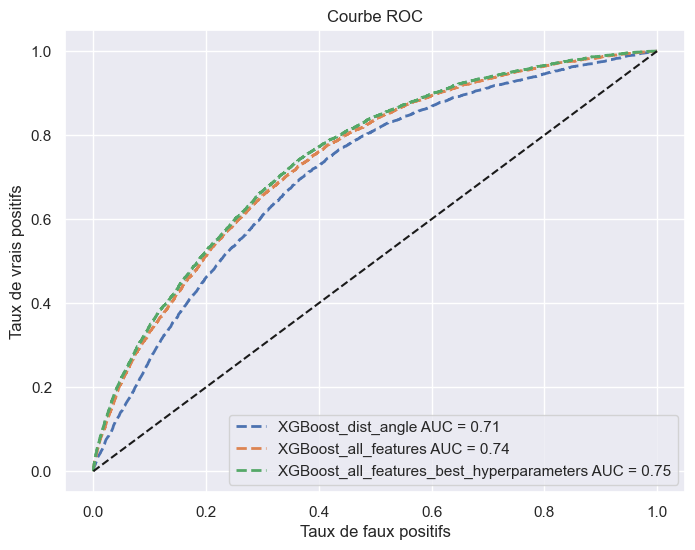

In [34]:
models = [model, model_2, best_model]
X_list = [X_valid, X_valid_2, X_valid_2]
y_list = [y_valid, y_valid_2, y_valid_2]
nom_models = ['XGBoost_dist_angle', 'XGBoost_all_features', 'XGBoost_all_features_best_hyperparameters']

plot_roc_auc(models, X_list, y_list, nom_models)

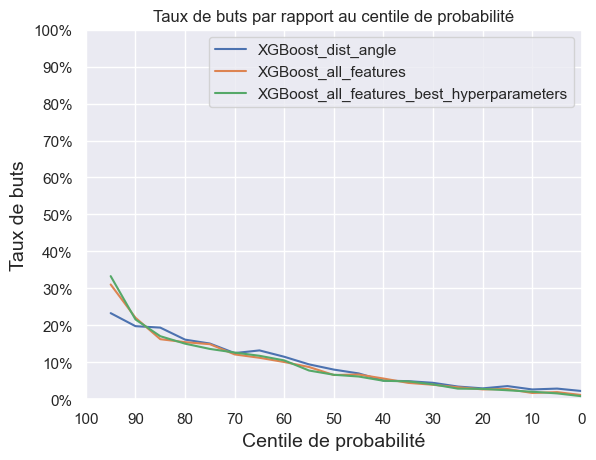

In [35]:
plot_taux_buts_par_centile(models, X_list, y_list, nom_models)

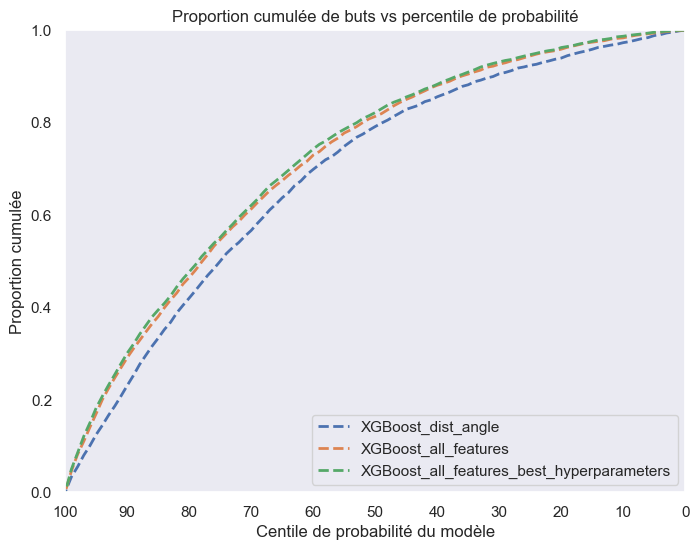

In [36]:
cumulative_goal_rate(models, X_list, y_list, nom_models)

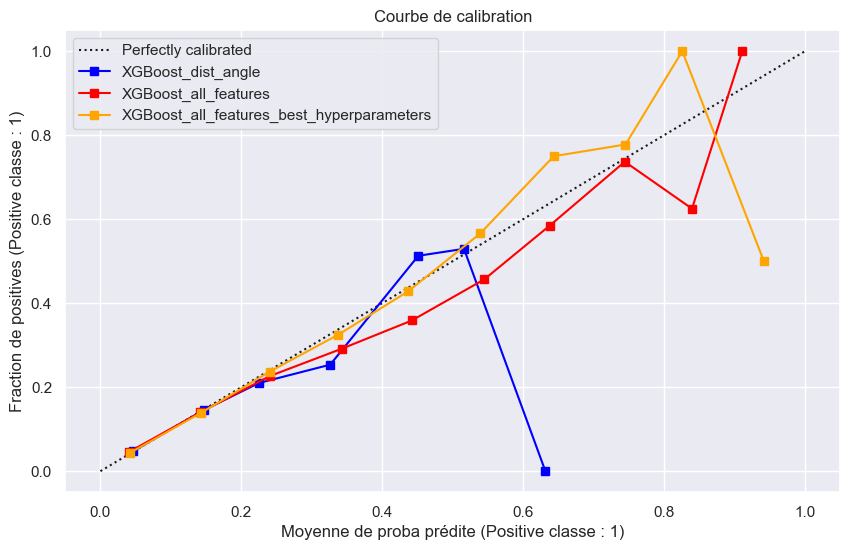

In [37]:
plot_calibration_curve(models, X_list, y_list, nom_models)

### 3. Sélection de caractéristiques

In [38]:
print(train_data_2.columns)
print(len(train_data_2.columns))

Index(['period', 'periodTimeInSeconds', 'isGoal', 'typeDeTir', 'x', 'y',
       'distanceToNet', 'relativeAngleToNet', 'previousEventTypeId',
       'previousX', 'previousY', 'distanceFromPrevious', 'timeDiff', 'rebond',
       'angleChange', 'vitesse', 'season'],
      dtype='object')
17


In [39]:
print(train_data_2_correct.columns)
print(len(train_data_2_correct.columns))

Index(['period', 'periodTimeInSeconds', 'isGoal', 'x', 'y', 'distanceToNet',
       'relativeAngleToNet', 'previousX', 'previousY', 'distanceFromPrevious',
       'timeDiff', 'rebond', 'angleChange', 'vitesse', 'season',
       'typeDeTir_Backhand', 'typeDeTir_Deflected', 'typeDeTir_Slap Shot',
       'typeDeTir_Snap Shot', 'typeDeTir_Tip-In', 'typeDeTir_Wrap-around',
       'typeDeTir_Wrist Shot', 'previousEventTypeId_BLOCKED_SHOT',
       'previousEventTypeId_FACEOFF', 'previousEventTypeId_GIVEAWAY',
       'previousEventTypeId_GOAL', 'previousEventTypeId_HIT',
       'previousEventTypeId_MISSED_SHOT', 'previousEventTypeId_PENALTY',
       'previousEventTypeId_SHOT', 'previousEventTypeId_TAKEAWAY'],
      dtype='object')
31


Sans compter 'isGoal', il y a 16 carcatéristiques voir même 30 lorsqu'elles sont préparés pour l'entraînement.

In [40]:
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.linear_model import Lasso
import shap

#### Analyse de corrélation

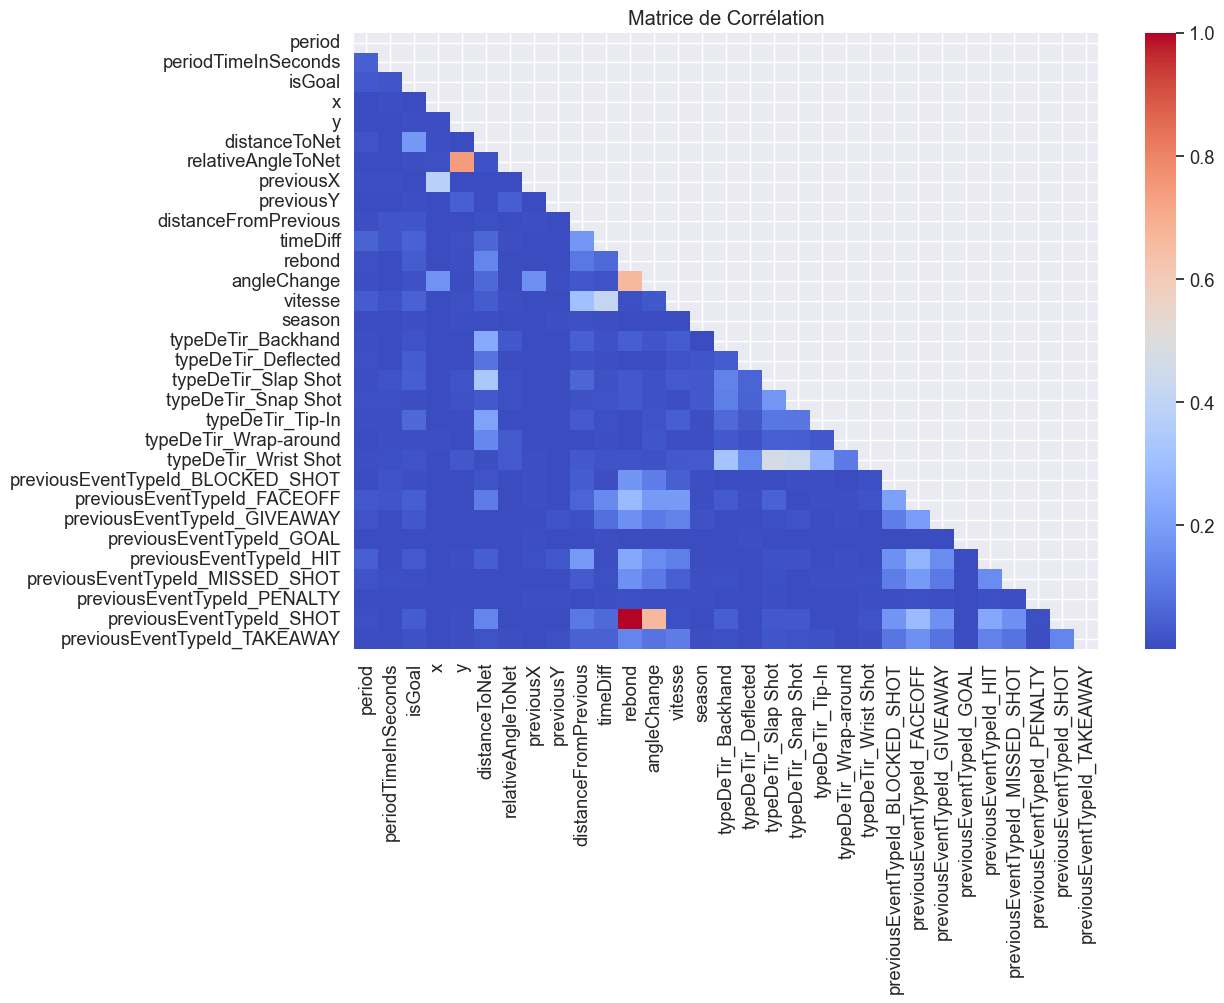

In [41]:
correlation_matrix = train_data_2_correct.corr().abs()

# Masque pour la partie supérieure de la matrice de corrélation
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Affichage de la matrice de corrélation
plt.figure(figsize=(12, 8))
sns.set(font_scale=1.2)
sns.heatmap(correlation_matrix, fmt=".2f", cmap="coolwarm", mask=mask)
plt.title("Matrice de Corrélation")

plt.show()

#### Régression Lasso

In [42]:
# Supprimer les colonnes non numériques
non_numeric_cols = train_data_2_correct.select_dtypes(exclude=['number']).columns
df_numeric = train_data_2_correct.drop(columns=non_numeric_cols)

# Séparer les caractéristiques catégorielles
categorical_features = train_data_2_correct.select_dtypes(include=['object']).columns

# Appliquer l'encodage one-hot aux caractéristiques catégorielles
df_encoded = pd.get_dummies(df_numeric, columns=categorical_features)

# Diviser les données en ensemble d'entraînement et de validation
X_train_lasso, X_valid_lasso, y_train_lasso, y_valid_lasso = train_test_split(df_encoded.drop(columns=['isGoal']), df_encoded['isGoal'], test_size=0.2, random_state=42)


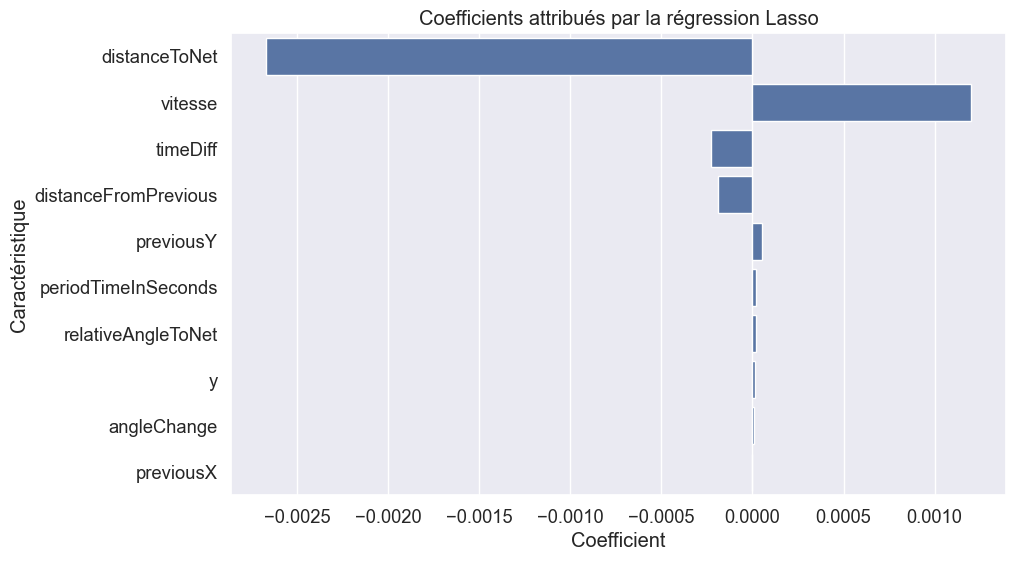

['distanceToNet', 'vitesse', 'timeDiff', 'distanceFromPrevious', 'previousY', 'periodTimeInSeconds', 'relativeAngleToNet', 'y', 'angleChange', 'previousX']


In [43]:
# Régression Lasso
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_lasso, y_train_lasso)

# Récupérer les coefficients
coefficients = lasso.coef_

# Créer un DataFrame pour visualiser les coefficients avec le nom des caractéristiques
coefficients_lasso = pd.DataFrame({'Feature': X_train_lasso.columns, 'Coefficient': coefficients})

# Filtrer les caractéristiques sélectionnées (coefficients non nuls)
selected_features_lasso = coefficients_lasso[coefficients_lasso['Coefficient'] != 0]

# Trier les caractéristiques par coefficient absolu (pour une meilleure visualisation)
selected_features_lasso = selected_features_lasso.sort_values(by='Coefficient', key=abs, ascending=False)

# Visualiser les caractéristiques sélectionnées
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=selected_features_lasso)
plt.title('Coefficients attribués par la régression Lasso')
plt.xlabel('Coefficient')
plt.ylabel('Caractéristique')
plt.show()

selected_features_lasso = list(selected_features_lasso['Feature'])
print(selected_features_lasso)

#### Sélection récursive de caractéristique (RFE)

In [44]:
# Sélection récursive de caractéristiques (RFE)
rfe = RFE(best_model, n_features_to_select=5)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_valid_rfe = rfe.transform(X_valid)

# Obtenez les noms des caractéristiques sélectionnées
selected_features_rfe = X_train.columns[rfe.support_]

print(selected_features_rfe)

Index(['distanceToNet', 'relativeAngleToNet'], dtype='object')


#### Importance des caractéristiques

In [45]:
# Importance des caractéristiques du modèle (XGBoost)
feature_importances = best_model.feature_importances_
selected_features_xgb = X_train_2.columns[feature_importances > 0.02]
print(selected_features_xgb)
print(len((selected_features_xgb)))
X_train_xgb = X_train_2[selected_features_xgb]
X_valid_xgb = X_valid_2[selected_features_xgb]

Index(['period', 'periodTimeInSeconds', 'y', 'distanceToNet', 'timeDiff',
       'rebond', 'vitesse', 'typeDeTir_Backhand', 'typeDeTir_Deflected',
       'typeDeTir_Slap Shot', 'typeDeTir_Snap Shot', 'typeDeTir_Tip-In',
       'typeDeTir_Wrap-around', 'typeDeTir_Wrist Shot',
       'previousEventTypeId_FACEOFF', 'previousEventTypeId_GIVEAWAY',
       'previousEventTypeId_HIT', 'previousEventTypeId_MISSED_SHOT'],
      dtype='object')
18


#### SHAP

[04:20:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


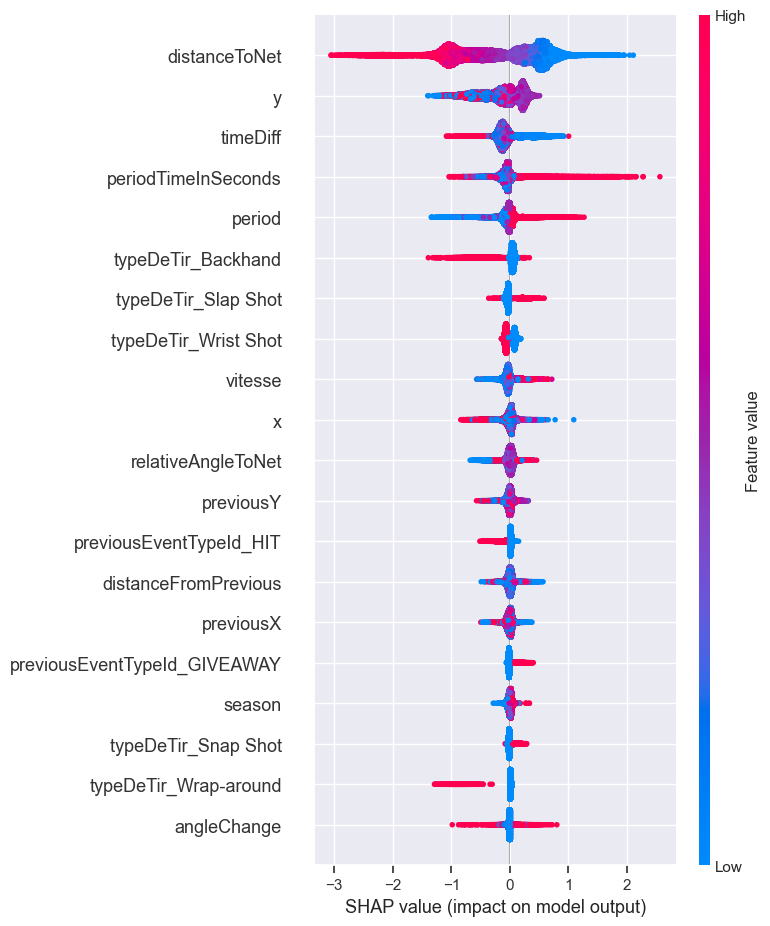

In [46]:
explainer = shap.TreeExplainer(best_model)  
shap_values = explainer.shap_values(X_valid_2)
shap.summary_plot(shap_values, X_valid_2)

In [47]:
# Sélection des caractéristiques basées sur SHAP
selected_features_shap = X_valid_2.columns[np.abs(shap_values).mean(axis=0) > 0.1]
print(selected_features_shap)
X_train_shap = X_train_2[selected_features_shap]
X_valid_shap = X_valid_2[selected_features_shap]


Index(['periodTimeInSeconds', 'y', 'distanceToNet', 'timeDiff'], dtype='object')


#### Entraînement de modèles avec les caractéristiques séléectionnées

In [48]:
print(train_data_2_correct.select_dtypes(include=['object']).columns)

Index([], dtype='object')


In [49]:
########### LASSO ############

# on garde que les caractéristique qu'on veut étudier ici
X_train_lasso = train_data_2_correct[selected_features_lasso]
y_train_lasso = train_data_2_correct['isGoal']

# split l'ensemble de données en ensembles d'entraînement et de validation
X_train_lasso, X_valid_lasso, y_train_lasso, y_valid_lasso = train_test_split(X_train_lasso, y_train_lasso, test_size=0.2, random_state=42)
# Initialisation et entrainement du modèle XGBoost
model_lasso = xgb.XGBClassifier(**best_hyperparameters)
model_lasso.fit(X_train_lasso, y_train_lasso)

# accuracy
y_pred_lasso = model_lasso.predict(X_valid_lasso)
acc_lasso = accuracy_score(y_valid_lasso, y_pred_lasso)
print(f"Accuracy select features avec lasso : {acc_lasso}")


############ RFE ############

# on garde que les caractéristique qu'on veut étudier ici
X_train_rfe = train_data_2_correct[selected_features_rfe]
y_train_rfe = train_data_2_correct['isGoal']
# split l'ensemble de données en ensembles d'entraînement et de validation
X_train_rfe, X_valid_rfe, y_train_rfe, y_valid_rfe = train_test_split(X_train_rfe, y_train_rfe, test_size=0.2, random_state=42)

# Initialisation et entrainement du modèle XGBoost
model_rfe = xgb.XGBClassifier(**best_hyperparameters)
model_rfe.fit(X_train_rfe, y_train_rfe)

# accuracy
y_pred_rfe = model_rfe.predict(X_valid_rfe)
acc_rfe = accuracy_score(y_valid_rfe, y_pred_rfe)
print(f"Accuracy select features avec rfe : {acc_rfe}")


############ xgb ############

# on garde que les caractéristique qu'on veut étudier ici
X_train_xgb = train_data_2_correct[selected_features_xgb]
y_train_xgb = train_data_2_correct['isGoal']
# split l'ensemble de données en ensembles d'entraînement et de validation
X_train_xgb, X_valid_xgb, y_train_xgb, y_valid_xgb = train_test_split(X_train_xgb, y_train_xgb, test_size=0.2, random_state=42)

# Initialisation et entrainement du modèle XGBoost
model_xgb = xgb.XGBClassifier(**best_hyperparameters)
model_xgb.fit(X_train_xgb, y_train_xgb)

# accuracy
y_pred_xgb = model_xgb.predict(X_valid_xgb)
acc_xgb = accuracy_score(y_valid_xgb, y_pred_xgb)
print(f"Accuracy select features avec xgb : {acc_xgb}")


############ shap ############

# on garde que les caractéristique qu'on veut étudier ici
X_train_shap = train_data_2_correct[selected_features_shap]
y_train_shap = train_data_2_correct['isGoal']
# split l'ensemble de données en ensembles d'entraînement et de validation
X_train_shap, X_valid_shap, y_train_shap, y_valid_shap = train_test_split(X_train_shap, y_train_shap, test_size=0.2, random_state=42)

# Initialisation et entrainement du modèle XGBoost
model_shap = xgb.XGBClassifier(**best_hyperparameters)
model_shap.fit(X_train_shap, y_train_shap)

# accuracy
y_pred_shap = model_shap.predict(X_valid_shap)
acc_shap = accuracy_score(y_valid_shap, y_pred_shap)
print(f"Accuracy select features avec shap : {acc_shap}")

Accuracy select features avec lasso : 0.9087591857420391
Accuracy select features avec rfe : 0.9087929723794239
Accuracy select features avec xgb : 0.9093504518962751
Accuracy select features avec shap : 0.9087929723794239


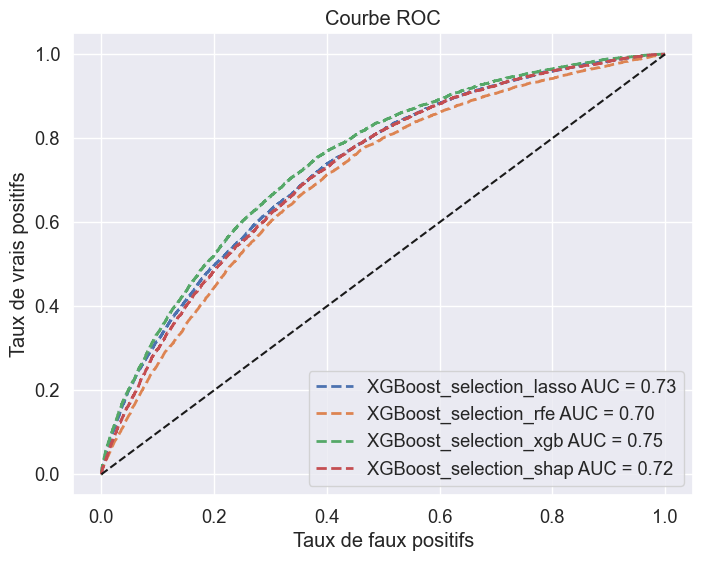

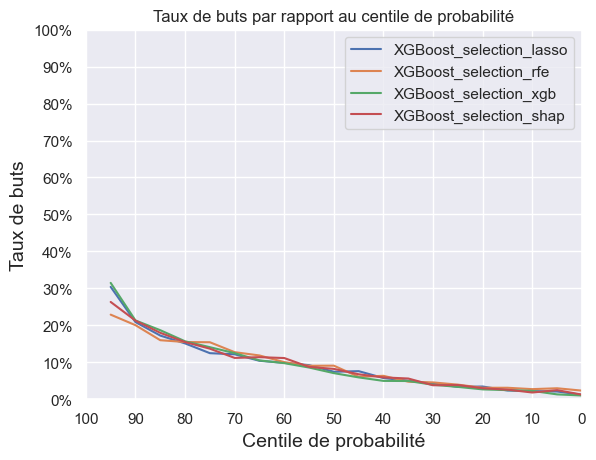

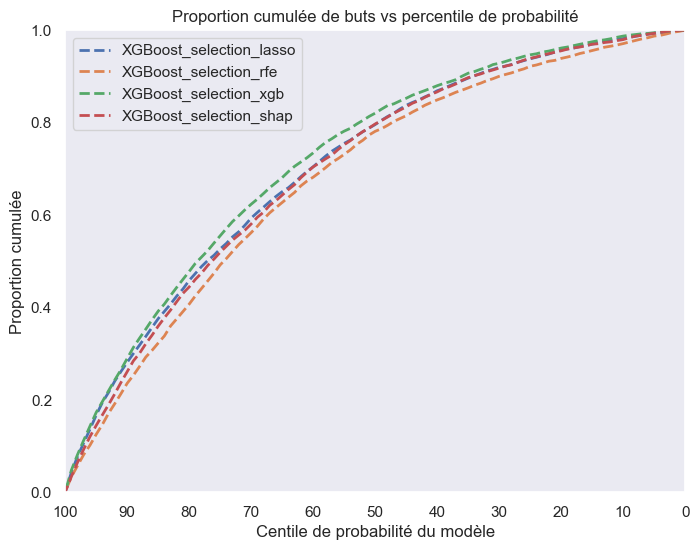

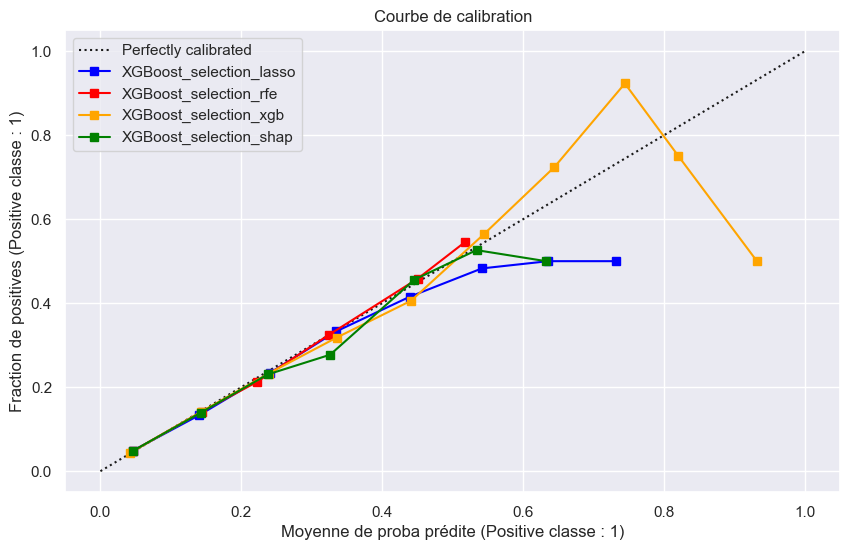

In [50]:
models = [model_lasso, model_rfe, model_xgb, model_shap]
X_list = [X_valid_lasso, X_valid_rfe, X_valid_xgb, X_valid_shap]
y_list = [y_valid_lasso, y_valid_rfe, y_valid_xgb, y_valid_shap]
nom_models = ['XGBoost_selection_lasso', 'XGBoost_selection_rfe', 'XGBoost_selection_xgb', 'XGBoost_selection_shap']

plot_roc_auc(models, X_list, y_list, nom_models)
plot_taux_buts_par_centile(models, X_list, y_list, nom_models)
cumulative_goal_rate(models, X_list, y_list, nom_models)
plot_calibration_curve(models, X_list, y_list, nom_models)

Les différences ne sont pas flagrantes mais on va tout de même conserver les caractéristiques séléctionnées par l'imortance des caractéristiques du modèle xgb : 

['period', 'periodTimeInSeconds', 'y', 'distanceToNet', 'timeDiff',
       'rebond', 'vitesse', 'typeDeTir_Backhand', 'typeDeTir_Deflected',
       'typeDeTir_Slap Shot', 'typeDeTir_Snap Shot', 'typeDeTir_Tip-In',
       'typeDeTir_Wrap-around', 'typeDeTir_Wrist Shot',
       'previousEventTypeId_FACEOFF', 'previousEventTypeId_GIVEAWAY',
       'previousEventTypeId_HIT', 'previousEventTypeId_MISSED_SHOT']

In [51]:
experience_comet = False

In [52]:
if experience_comet : 
    experience = Experiment(
        api_key=os.environ.get(comet_api_key),
        project_name='milestone2',
        workspace='ift6758-a02',
    )
    experience.set_name("XGBoost model all features with best hyperparameters")

# Initialisation et entraîenement du modèle XGBoost 
model_xgb = xgb.XGBClassifier(**best_hyperparameters)
model_xgb.fit(X_train_xgb, y_train_xgb)

y_pred_xgb = model_xgb.predict(X_valid_xgb)

# Afficher l'accuracy du modèle avec les meilleurs hyperparamètres sur l'ensemble de validation
accuracy_xgb = accuracy_score(y_valid_xgb, y_pred_xgb)
print(f"Accuracy : {accuracy_xgb}")

if experience_comet : 

    pickle.dump(model, open("models/best_XGBoost_selected_features_xgb.json", "wb"))

    experience.log_model("best XGBoost model", "models/best_XGBoost_selected_features_xgb.json")
    experience.log_confusion_matrix(y_true=y_valid, y_predicted=y_pred, title="best XGBoost Confusion Matrix")
    experience.log_parameters(best_hyperparameters)
    experience.log_metric("best accuracy", accuracy_xgb)
    experience.add_tag("XGBoost")

    experience.end()

Accuracy : 0.9093504518962751


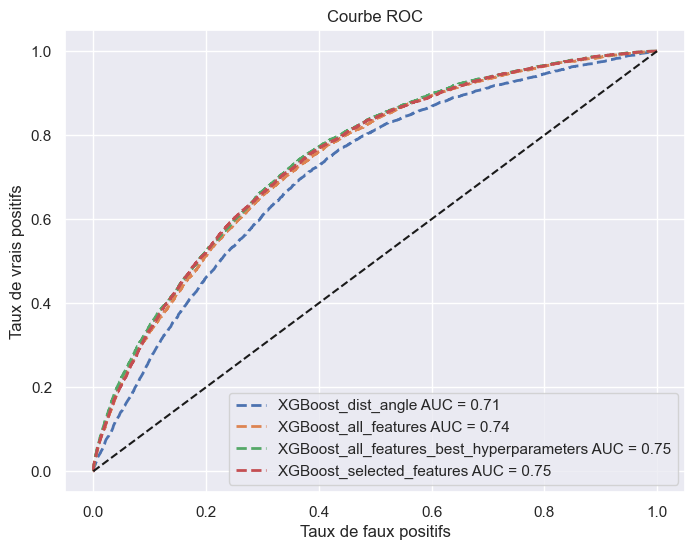

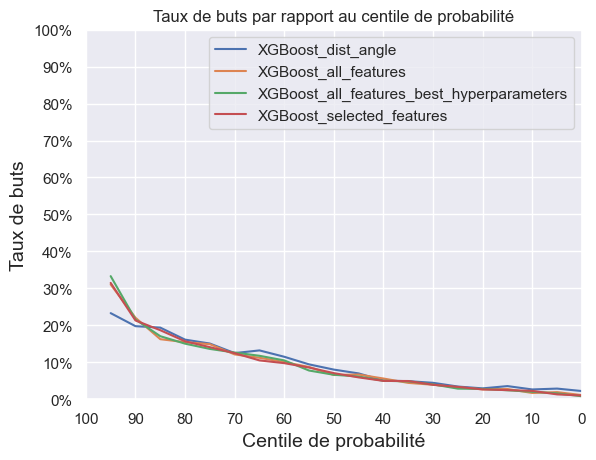

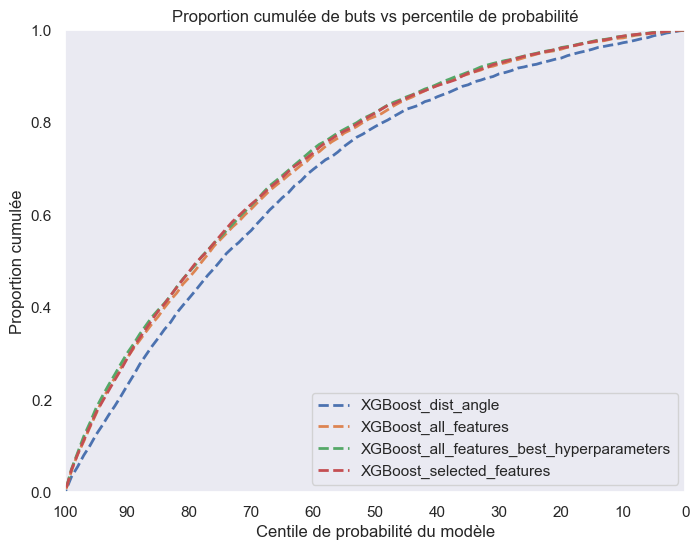

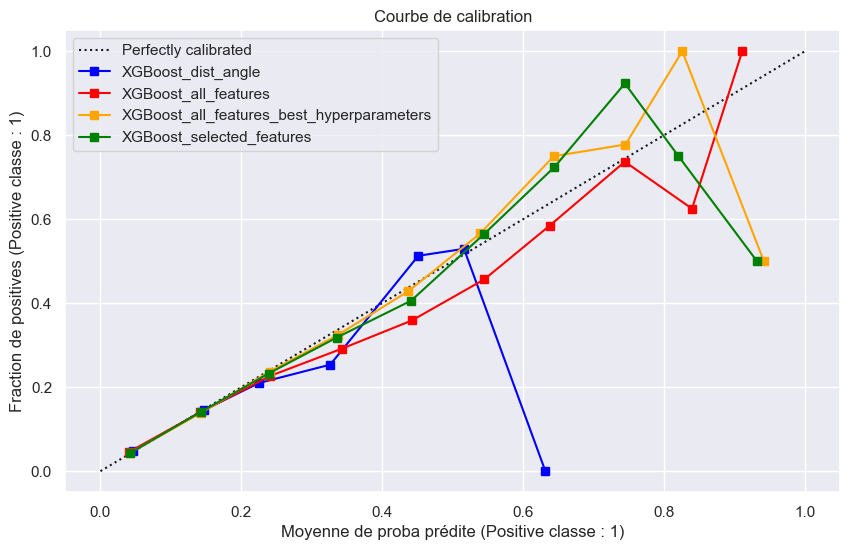

In [53]:
models = [model, model_2, best_model, model_xgb]
X_list = [X_valid, X_valid_2, X_valid_2, X_valid_xgb]
y_list = [y_valid, y_valid_2, y_valid_2, y_valid_xgb]
nom_models = ['XGBoost_dist_angle', 'XGBoost_all_features', 'XGBoost_all_features_best_hyperparameters', 'XGBoost_selected_features']

plot_roc_auc(models, X_list, y_list, nom_models)
plot_taux_buts_par_centile(models, X_list, y_list, nom_models)
cumulative_goal_rate(models, X_list, y_list, nom_models)
plot_calibration_curve(models, X_list, y_list, nom_models)